In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom, norm
from scipy.optimize import brentq
from tqdm import tqdm

In [2]:
def av_pH_square(d0, L):
    coef = 1 + 2*d0**2 * L
    return d0 * np.sqrt(2*L / coef) * np.exp(-L/2/coef)

# Analytical and numerical computation for setting the parameters in the evolutionary model

## Recruiting probability of clonotypes

Assuming a string model of binary spins of length $L$, we consider the target antigen as a string of zeros, and the repertoire is composed of $N\approx 10^7$ random strings.
The probability for a receptor of having Hamming distance equal to $H$ is a binomial distribtuion:
$$
H \sim \text{Binom} \left( L, \frac{1}{2} \right) \approx \mathcal{N} \left( \frac{L}{2}, \frac{L}{4} \right) .
$$
which can be approximated as a Gaussian.

For the calculation it is useful to define the "intensive" variable $h$ as:
$$
h = H/L \sim \mathcal{N} \left( \frac{1}{2}, \frac{1}{4 L} \right) .
$$

The recruitment probability is then defined as:
$$
p(H) = \exp \left[ - \left( H/D_0 \right)^\gamma \right], \;\;\; p(h) = L \exp \left[ - \left( h/d_0 \right)^\gamma \right], \; \text{where} \; D_0 = L d_0
$$
where we assume that the parameter $D_0$ is extensive in $L$ and we rewrite the probability in terms of the intensive variables. $\gamma$ and $d_0$ will be the two parameters to tune to obtain the desired number of recruited clonotypes (for later).

The average of this probability reads:
$$
\langle p(H) \rangle = \langle p(h) \rangle / L = \sqrt{\frac{2L}{\pi}} \int dh \exp \left[ - \left( h/d_0 \right)^\gamma - 2 L \left( \frac{1}{2} - h \right)^2 \right] \coloneqq \sqrt{\frac{2L}{\pi}} \int dh \exp \left[ L g(h) \right].
$$
This defines an integral that for large $L$ can be approximated with a saddle point around the maximum of the following function:
$$
g(h) = - \frac{1}{L} \left( \frac{h}{d_0} \right)^\gamma - 2 \left( \frac{1}{2} - h \right)^2
$$
$$
g'(h) = - \frac{\gamma }{L} \left( \frac{h}{d_0} \right)^\gamma \frac{1}{h} + 4 \left( \frac{1}{2} - h \right)
$$
$$
g''(h) = -\frac{\gamma (\gamma - 1)}{L}  \left( \frac{h}{d_0} \right)^\gamma \frac{1}{h^2} - 4
$$
In general, the maximum cannot be found analytically, but we can study two sovable special cases to test the approximation.

#### Analytical solution for $\gamma=1$
We do not need the saddle, point, we have a gaussian integral!
$$
\langle p(H) \rangle = \sqrt{\frac{2}{\pi L}} \int dH \exp \left[ - \frac{H}{D_0} - \frac{2}{L} \left( \frac{L}{2} - H \right)^2 \right]
$$
$$
\langle p(H) \rangle = \sqrt{\frac{2}{\pi L}} \exp \left[ \frac{L(1 - 4 D_0)}{8 D_0^2} \right] \int dH \exp \left[ -\frac{2}{L} \left(H - \left( \frac{L}{2} - \frac{L}{4 D_0} \right) \right)^2 \right] = \exp \left[ \frac{L(1 - 4 D_0)}{8 D_0^2} \right] \approx \exp \left[ - \frac{1}{2 d_0} \right]
$$

$$
\log \langle p(H) \rangle = -\frac{1}{2 d_0} + \frac{1}{8 L d_0^2}, \;\;\; d_0 = -\frac{1 + \sqrt{1 + 2 \log \langle p \rangle / L }}{4 \log \langle p \rangle} \approx -\frac{1}{2 \log \langle p(H) \rangle}
$$

#### Analytical solution for $\gamma = 2$
$$
\langle p(H) \rangle = \sqrt{\frac{2}{\pi L}} \int dH \exp \left[ - \left(\frac{H}{D_0}\right)^2 - \frac{2}{L} \left( \frac{L}{2} - H \right)^2 \right]
$$
$$
\langle p(H) \rangle = \sqrt{\frac{2}{\pi L}} \exp \left[ -\frac{L^2}{2 (L + 2 D_0^2)} \right] \int dH \exp \left[ -\left( \frac{L+2 D_0^2}{L D_0^2} \right) \left(H - \frac{L D_0^2}{L+2 D_0^2} \right)^2 \right]
$$
$$
\langle p(H) \rangle = \sqrt{\frac{2 D_0^2}{L+2 D_0^2} } \exp \left[ -\frac{L^2}{2 (L + 2 D_0^2)} \right] \approx \exp \left[ - \frac{1}{4 d_0^2} \right]
$$

### Checking the approximations for the two analytically solvable cases

In [17]:
Ls = np.logspace(0, 3, 20, dtype=int)
d0 = 0.33
N = 10**5

D0s = Ls * d0

gamma1 = 1
av_ps_1 = []
for i, L in enumerate(Ls):
    h_dist = binom(L, 0.5).rvs(N)
    probs = np.exp(-(h_dist/D0s[i])**gamma1)
    av_ps_1.append(np.mean(probs))

gamma2 = 2
av_ps_2 = []
for i, L in enumerate(Ls):
    h_dist = binom(L, 0.5).rvs(N)
    probs = np.exp(-(h_dist/D0s[i])**gamma2)
    av_ps_2.append(np.mean(probs))

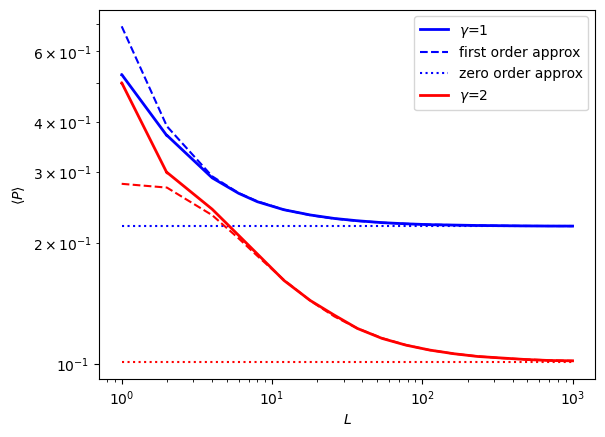

In [18]:
plt.loglog()
plt.xlabel(r'$L$')
plt.ylabel(r'$\langle P \rangle$')

plt.plot(Ls, av_ps_1, c='b', lw=2, label=r'$\gamma$=%.g'%gamma1)
plt.plot(Ls, np.exp(-Ls/2/D0s * (1 - 1/4/D0s)), c='b', ls='--', label='first order approx')
plt.plot(Ls, np.ones(len(Ls))*np.exp(-1/2/d0), c='b', ls=':', label='zero order approx')

plt.plot(Ls, av_ps_2, c='r', lw=2, label=r'$\gamma$=%.g'%gamma2)
#aux = 1 + 2*d0**2*Ls
plt.plot(Ls, av_pH_square(d0, Ls), c='r', ls='--')
plt.plot(Ls, np.ones(len(Ls))*np.exp(-1/4/d0**2), c='r', ls=':')
plt.legend()

### Testing the recruitment process 

We want to choose $d_0$ such that the number of recruited clonotypes is $N=100$. We can fix its value by analytical computation and check the generated number of clonotypes.

In [44]:
L, N_tots = 20, np.array([10**5, 10**6, 10**7])
N_recruit = 100
R = 200

# Choosing d0 to satisfy the recruitment number using the saddle point approx
log_av_p_recrs = np.log(N_recruit / N_tots)
vals = 1 + 2*log_av_p_recrs / L
d0s1 = - (1 + np.sqrt(np.where(vals > 0, vals, 0))) / 4 / log_av_p_recrs
d0s2 = np.array([brentq(lambda x : av_pH_square(x, L) - N_recruit / N, 0.01, 0.5) for N in N_tots])

h_recruit_post1, h_recruit_post2 = [], []
#progress = tqdm(total=R)
for r in range(R):

    h_aux1, h_aux2 = [], []
    for i, N_tot in enumerate(N_tots):
    
        # Generating hamming distances
        h_dists = binom(L, 0.5).rvs(N_tot)
        
        # Computin prob with gamma = 1 and gamma = 2
        recruit_prob1 = np.exp(-h_dists/d0s1[i]/L)
        recruit_prob2 = np.exp(-(h_dists/d0s2[i]/L)**2)
        
        # Selecting the clonotypes according to their recruitment prob
        unifs = np.random.rand(N_tot)
        h_recruit1 = h_dists[unifs < recruit_prob1]
        h_recruit2 = h_dists[unifs < recruit_prob2]
    
        h_aux1.append(h_recruit1)
        h_aux2.append(h_recruit2)

    h_recruit_post1.append(h_aux1)
    h_recruit_post2.append(h_aux2)
    print(r, end='\r', flush=True)
    

199

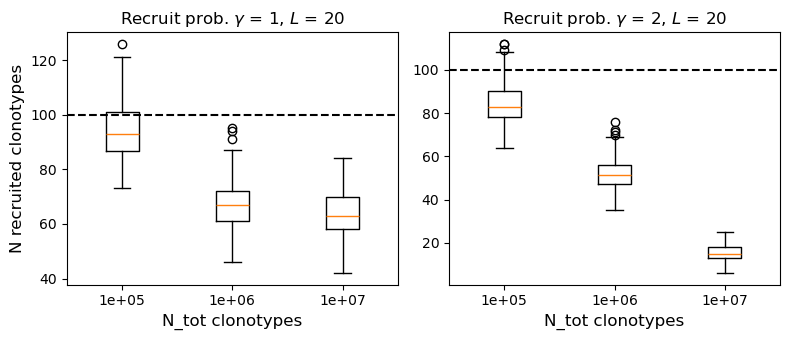

In [45]:
N_recruit_posts1, N_recruit_posts2 = [], []
for i, N_tot in enumerate(N_tots):
    N_recruit_posts1.append([len(hs[i]) for hs in h_recruit_post1])
    N_recruit_posts2.append([len(hs[i]) for hs in h_recruit_post2])


labels = ['%.g'%N for N in N_tots]

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3.5))

ax1.set_title(r'Recruit prob. $\gamma$ = 1, $L$ = %.i'%L)
ax1.set_xlabel('N_tot clonotypes', fontsize=12)
ax1.set_ylabel('N recruited clonotypes', fontsize=12)
ax1.plot([0.5,3.5],[100,100], c='k', ls='--')
bplot = ax1.boxplot(N_recruit_posts1, tick_labels=labels)

ax2.set_title(r'Recruit prob. $\gamma$ = 2, $L$ = %.i'%L)
ax2.set_xlabel('N_tot clonotypes', fontsize=12)
#ax2.set_ylabel('N recruited clonotypes', fontsize=12)
ax2.plot([0.5,3.5],[100,100], c='k', ls='--')
bplot = ax2.boxplot(N_recruit_posts2, tick_labels=labels)

plt.tight_layout()
plt.savefig(f'plots/evo_model/test_N_recruit_L={L}.svg', facecolor='w')

## Testing the gaussian prediction for the hamming distance after recruitment

The probability density that a clonotype with distance $H$ passes the recruitment is
$$
P_{\rm pass} (H) \propto 2^{-L} \binom{L}{H} \exp \left[ -\left( \frac{H}{D_0} \right)^\gamma \right] \approx \exp \left[ - \left(\frac{H}{D_0}\right)^\gamma - \frac{2}{L} \left( \frac{L}{2} - H \right)^2 \right]
$$
where the gaussian approximation holds only for large $L$ and $H$. Below we test when this is approximately true of the two values of $\gamma$ that allows to recast this distribution as a Gaussian.

For $\gamma = 1$
$$
P_{pass}(H) = \mathcal{N} \left( \frac{L}{2} - \frac{1}{4 d_0}, \frac{L}{4} \right)
$$

For $\gamma = 2$
$$
P_{pass}(H) = \mathcal{N} \left( \frac{L^2 d_0^2}{1 + 2 L d_0^2}, \frac{L^2 d_0^2}{2(1 + 2 L d_0^2)} \right)
$$

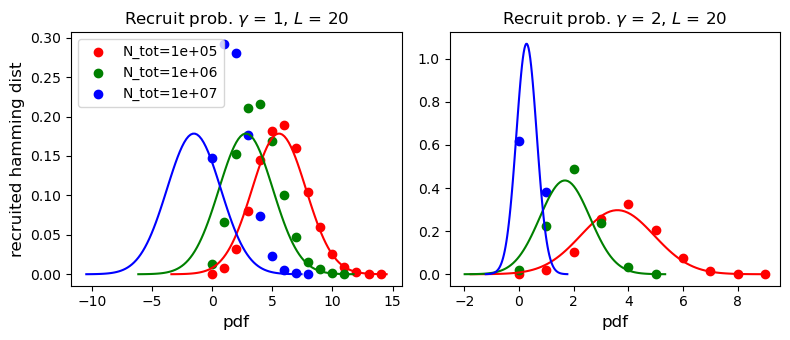

In [46]:
all_hs1, all_hs2 = [], []
for i, N_tot in enumerate(N_tots):
    aux1, aux2 = [], []
    for r in range(R):
        aux1.extend(h_recruit_post1[r][i])
        aux2.extend(h_recruit_post2[r][i])
    all_hs1.append(aux1)
    all_hs2.append(aux2)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3.5))
colors = ['r', 'g', 'b']

ax1.set_title(r'Recruit prob. $\gamma$ = 1, $L$ = %.i'%L)
ax1.set_xlabel('pdf', fontsize=12)
ax1.set_ylabel('recruited hamming dist', fontsize=12)

for i, N_tot in enumerate(N_tots):
    h_uni1, h_count1 = np.unique(all_hs1[i], return_counts=True)
    h=ax1.scatter(h_uni1, h_count1/h_count1.sum(), label=f'N_tot=%.g'%N_tot, c=colors[i])
    mu = L/2 - 1/4/d0s1[i]
    std = np.sqrt(L)/2
    hs = np.linspace(mu-4*std, mu+4*std, 100)
    ax1.plot(hs, norm(mu, std).pdf(hs), c=colors[i])
    
#ax1.legend(loc=2)

ax2.set_title(r'Recruit prob. $\gamma$ = 2, $L$ = %.i'%L)
ax2.set_xlabel('pdf', fontsize=12)
#ax1.set_ylabel('recruited hamming dist', fontsize=12)
for i, N_tot in enumerate(N_tots):
    h_uni2, h_count2 = np.unique(all_hs2[i], return_counts=True)
    h=ax2.scatter(h_uni2, h_count2/h_count2.sum(), label=f'N_tot=%.g'%N_tot, c=colors[i])
    mu = L**2 * d0s2[i]**2 / (1 + 2*L*d0s2[i]**2)
    std = np.sqrt(mu/2)
    hs = np.linspace(mu-4*std, mu+4*std, 100)
    ax2.plot(hs, norm(mu, std).pdf(hs), c=colors[i])

ax1.legend(loc=0)

plt.tight_layout()
plt.savefig(f'plots/evo_model/test_h_recruit_L={L}.svg', facecolor='w')

In [48]:
2**(-20)

9.5367431640625e-07